In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.colors import LinearSegmentedColormap, Normalize
import matplotlib.gridspec as gridspec
import numpy as np

from PIL import Image
import urllib
import json
import os


In [109]:
plt.style.use("./assets/stylesheets/soc_base.mplstyle")
light_color = ('#d1d3d4', '#FBFBFB', '#FFFFFF',
               '#EBEBE9', '#97c1e7', '#FAFAFF', '#FBFBEF')
def colorFader(c1, c2, mix=0):
    c1 = np.array(mcolors.to_rgb(c1))
    c2 = np.array(mcolors.to_rgb(c2))
    return mcolors.to_hex((1-mix)*c1 + mix*c2)

In [110]:
# EPL
# league_id = 47
# league_name = "Premier League"
# filename = 'epl_xg_rolling'
# df = pd.read_csv('data/epl_xg.csv', index_col=0)
# df = df.sort_values(by='date').reset_index(drop=True)
# teams_color = pd.read_csv('data/epl_teams.csv')

In [111]:
# # Serie A
# league_id = 55
# league_name = "Serie A"
# filename = 'serie_a_xg_rolling'
# df2021 = pd.read_csv('data/seriea_xg_2021.csv', index_col=0)
# df2122 = pd.read_csv('data/seriea_xg_2122.csv', index_col=0)
# df2223 = pd.read_csv('data/seriea_xg_2223.csv', index_col=0)
# df = pd.concat([df2021, df2122, df2223]).reset_index(drop=True)
# df = df.sort_values(by='date').reset_index(drop=True)
# teams_color = pd.read_csv('data/serie_a_teams.csv')

In [112]:
# Bundesliga
league_id = 54
league_name = "Bundesliga"
filename = 'bundesliga_xg_rolling'
df2021 = pd.read_csv('data/bundesliga_xg_2021.csv', index_col=0)
df2122 = pd.read_csv('data/bundesliga_xg_2122.csv', index_col=0)
df2223 = pd.read_csv('data/bundesliga_xg_2223.csv', index_col=0)
df = pd.concat([df2021, df2122, df2223]).reset_index(drop=True)
df = df.sort_values(by='date').reset_index(drop=True)
teams_color = pd.read_csv('data/bundesliga_teams.csv')

In [113]:
def get_xG_rolling_data(team_id, window=10, data=df):
    df = data.copy()
    df_xg = df[(df['team_id'] == team_id) & (
        df['variable'].isin(['xG_for', 'xG_ag']))]
    df_xg = (
        df_xg.pivot(
            index=['date', 'match_id', 'team_id', 'team_name'],
            columns=['variable'],
            values=['value']
        ).reset_index()
        .droplevel(level=0, axis=1)
    )
    df_xg.columns = ['date', 'match_id',
                     'team_id', 'team_name', 'xG_ag', 'xG_for']
    df_xg['rolling_xG_for'] = df_xg['xG_for'].rolling(
        window=window, min_periods=0).mean()
    df_xg['rolling_xG_ag'] = df_xg['xG_ag'].rolling(
        window=window, min_periods=0).mean()
    df_xg['rolling_diff'] = df_xg['rolling_xG_for'] - df_xg['rolling_xG_ag']
    return df_xg


In [114]:
def get_xG_interpolated_df(team_id, window=10, data=df):
    df_xG = get_xG_rolling_data(team_id, window, data)
    df_xG['match_number'] = df_xG.index

    X_aux = df_xG.match_number.copy()
    X_aux.index = X_aux * 10
    last_idx = X_aux.index[-1]+1
    X_aux = X_aux.reindex(range(last_idx))
    X_aux = X_aux.interpolate()

    Y_for_aux = df_xG.rolling_xG_for.copy()
    Y_for_aux.index = Y_for_aux.index * 10
    last_idx = Y_for_aux.index[-1]+1
    Y_for_aux = Y_for_aux.reindex(range(last_idx))
    Y_for_aux = Y_for_aux.interpolate()

    Y_ag_aux = df_xG.rolling_xG_ag.copy()
    Y_ag_aux.index = Y_ag_aux.index * 10
    last_idx = Y_ag_aux.index[-1]+1
    Y_ag_aux = Y_ag_aux.reindex(range(last_idx))
    Y_ag_aux = Y_ag_aux.interpolate()

    Z_diff_aux = df_xG.rolling_diff.copy()
    Z_diff_aux.index = Z_diff_aux.index * 10
    last_idx = Z_diff_aux.index[-1]+1
    Z_diff_aux = Z_diff_aux.reindex(range(last_idx))
    Z_diff_aux = Z_diff_aux.interpolate()

    df_aux = pd.DataFrame({
        'X': X_aux,
        'Y_for': Y_for_aux,
        'Y_ag': Y_ag_aux,
        'Z': Z_diff_aux
    })
    return df_aux

In [115]:
def plot_xG_gradient(ax, team_id, window=10, data=df):
    df_xg = get_xG_rolling_data(team_id, window, data)
    df_aux_xg = get_xG_interpolated_df(team_id, window, data)

    ax.set_ylim(0, 4)
    ax.set_xlim(-0.5, df_xg.shape[0])
    
    # if team_id == 9823 :
    #     ax.set_ylim(0,5)        
    
    ax.grid(ls='-.', color='lightgrey')

    # color_2 = big_six_cm[str(team_id)]['high']
    # color_1 = big_six_cm[str(team_id)]['low']

    color_1 = teams_color[teams_color['team_id'] == team_id].iloc[0]['color1']
    color_2 = teams_color[teams_color['team_id'] == team_id].iloc[0]['color2']

    ax.plot(df_xg.index, df_xg['rolling_xG_for'], color=color_2, zorder=4)
    ax.plot(df_xg.index, df_xg['rolling_xG_ag'], color=color_1, zorder=4)
    ax.fill_between(x=[-.5, window],
                    y1=ax.get_ylim()[0],
                    y2=ax.get_ylim()[1],
                    alpha=.15,
                    color='black',
                    ec='None',
                    zorder=2)
    vmin = df_xg['rolling_diff'].min()
    vmax = df_xg['rolling_diff'].max()
    vmax = max(abs(vmin), abs(vmax))
    vmin = -1*vmax

    for i in range(0, len(df_aux_xg['X'])-1):
        ax.fill_between(
            [df_aux_xg['X'].iloc[i], df_aux_xg['X'].iloc[i+1]],
            [df_aux_xg['Y_for'].iloc[i], df_aux_xg['Y_for'].iloc[i+1]],
            [df_aux_xg['Y_ag'].iloc[i], df_aux_xg['Y_ag'].iloc[i+1]],
            color=colorFader(color_1, color_2, mix=(
                (df_aux_xg['Z'].iloc[i]-vmin)/(vmax-vmin))),
            zorder=3, alpha=.3
        )
    for x in [34, 34*2]:
        ax.plot([x, x],
                [ax.get_ylim()[0], ax.get_ylim()[1]],
                color='black',
                alpha=.35,
                zorder=2,
                ls='dashdot',
                lw=.95)
    for x in [22, 56]:
        if x == 22:
            text = '20/21 season'
        else:
            text = '21/22 season'
        text_ = ax.annotate(
            xy=(x, 2.75),
            text=text,
            color='black',
            size=7,
            va='center',
            ha='center',
            weight='bold',
            zorder=4
        )
        text_.set_path_effects([path_effects.Stroke(
            linewidth=1.5, foreground='white'), path_effects.Normal()])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(17))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(.5))

    return ax

In [116]:
# def path_effect_stroke(**kwargs):
#     return [path_effects.Stroke(**kwargs), path_effects.Normal()]


# pe = path_effect_stroke(linewidth=1.5, foreground="black")

(1/15) drawing Bayern München...
(2/15) drawing Borussia Dortmund...
(3/15) drawing RB Leipzig...
(4/15) drawing Bayer Leverkusen...
(5/15) drawing Union Berlin...
(6/15) drawing Hertha BSC...
(7/15) drawing TSG Hoffenheim...
(8/15) drawing Freiburg...
(9/15) drawing Augsburg...
(10/15) drawing Wolfsburg...
(11/15) drawing 1. FC Köln...
(12/15) drawing Borussia M'Gladbach...
(13/15) drawing Eintracht Frankfurt...
(14/15) drawing VfB Stuttgart...
(15/15) drawing Mainz 05...


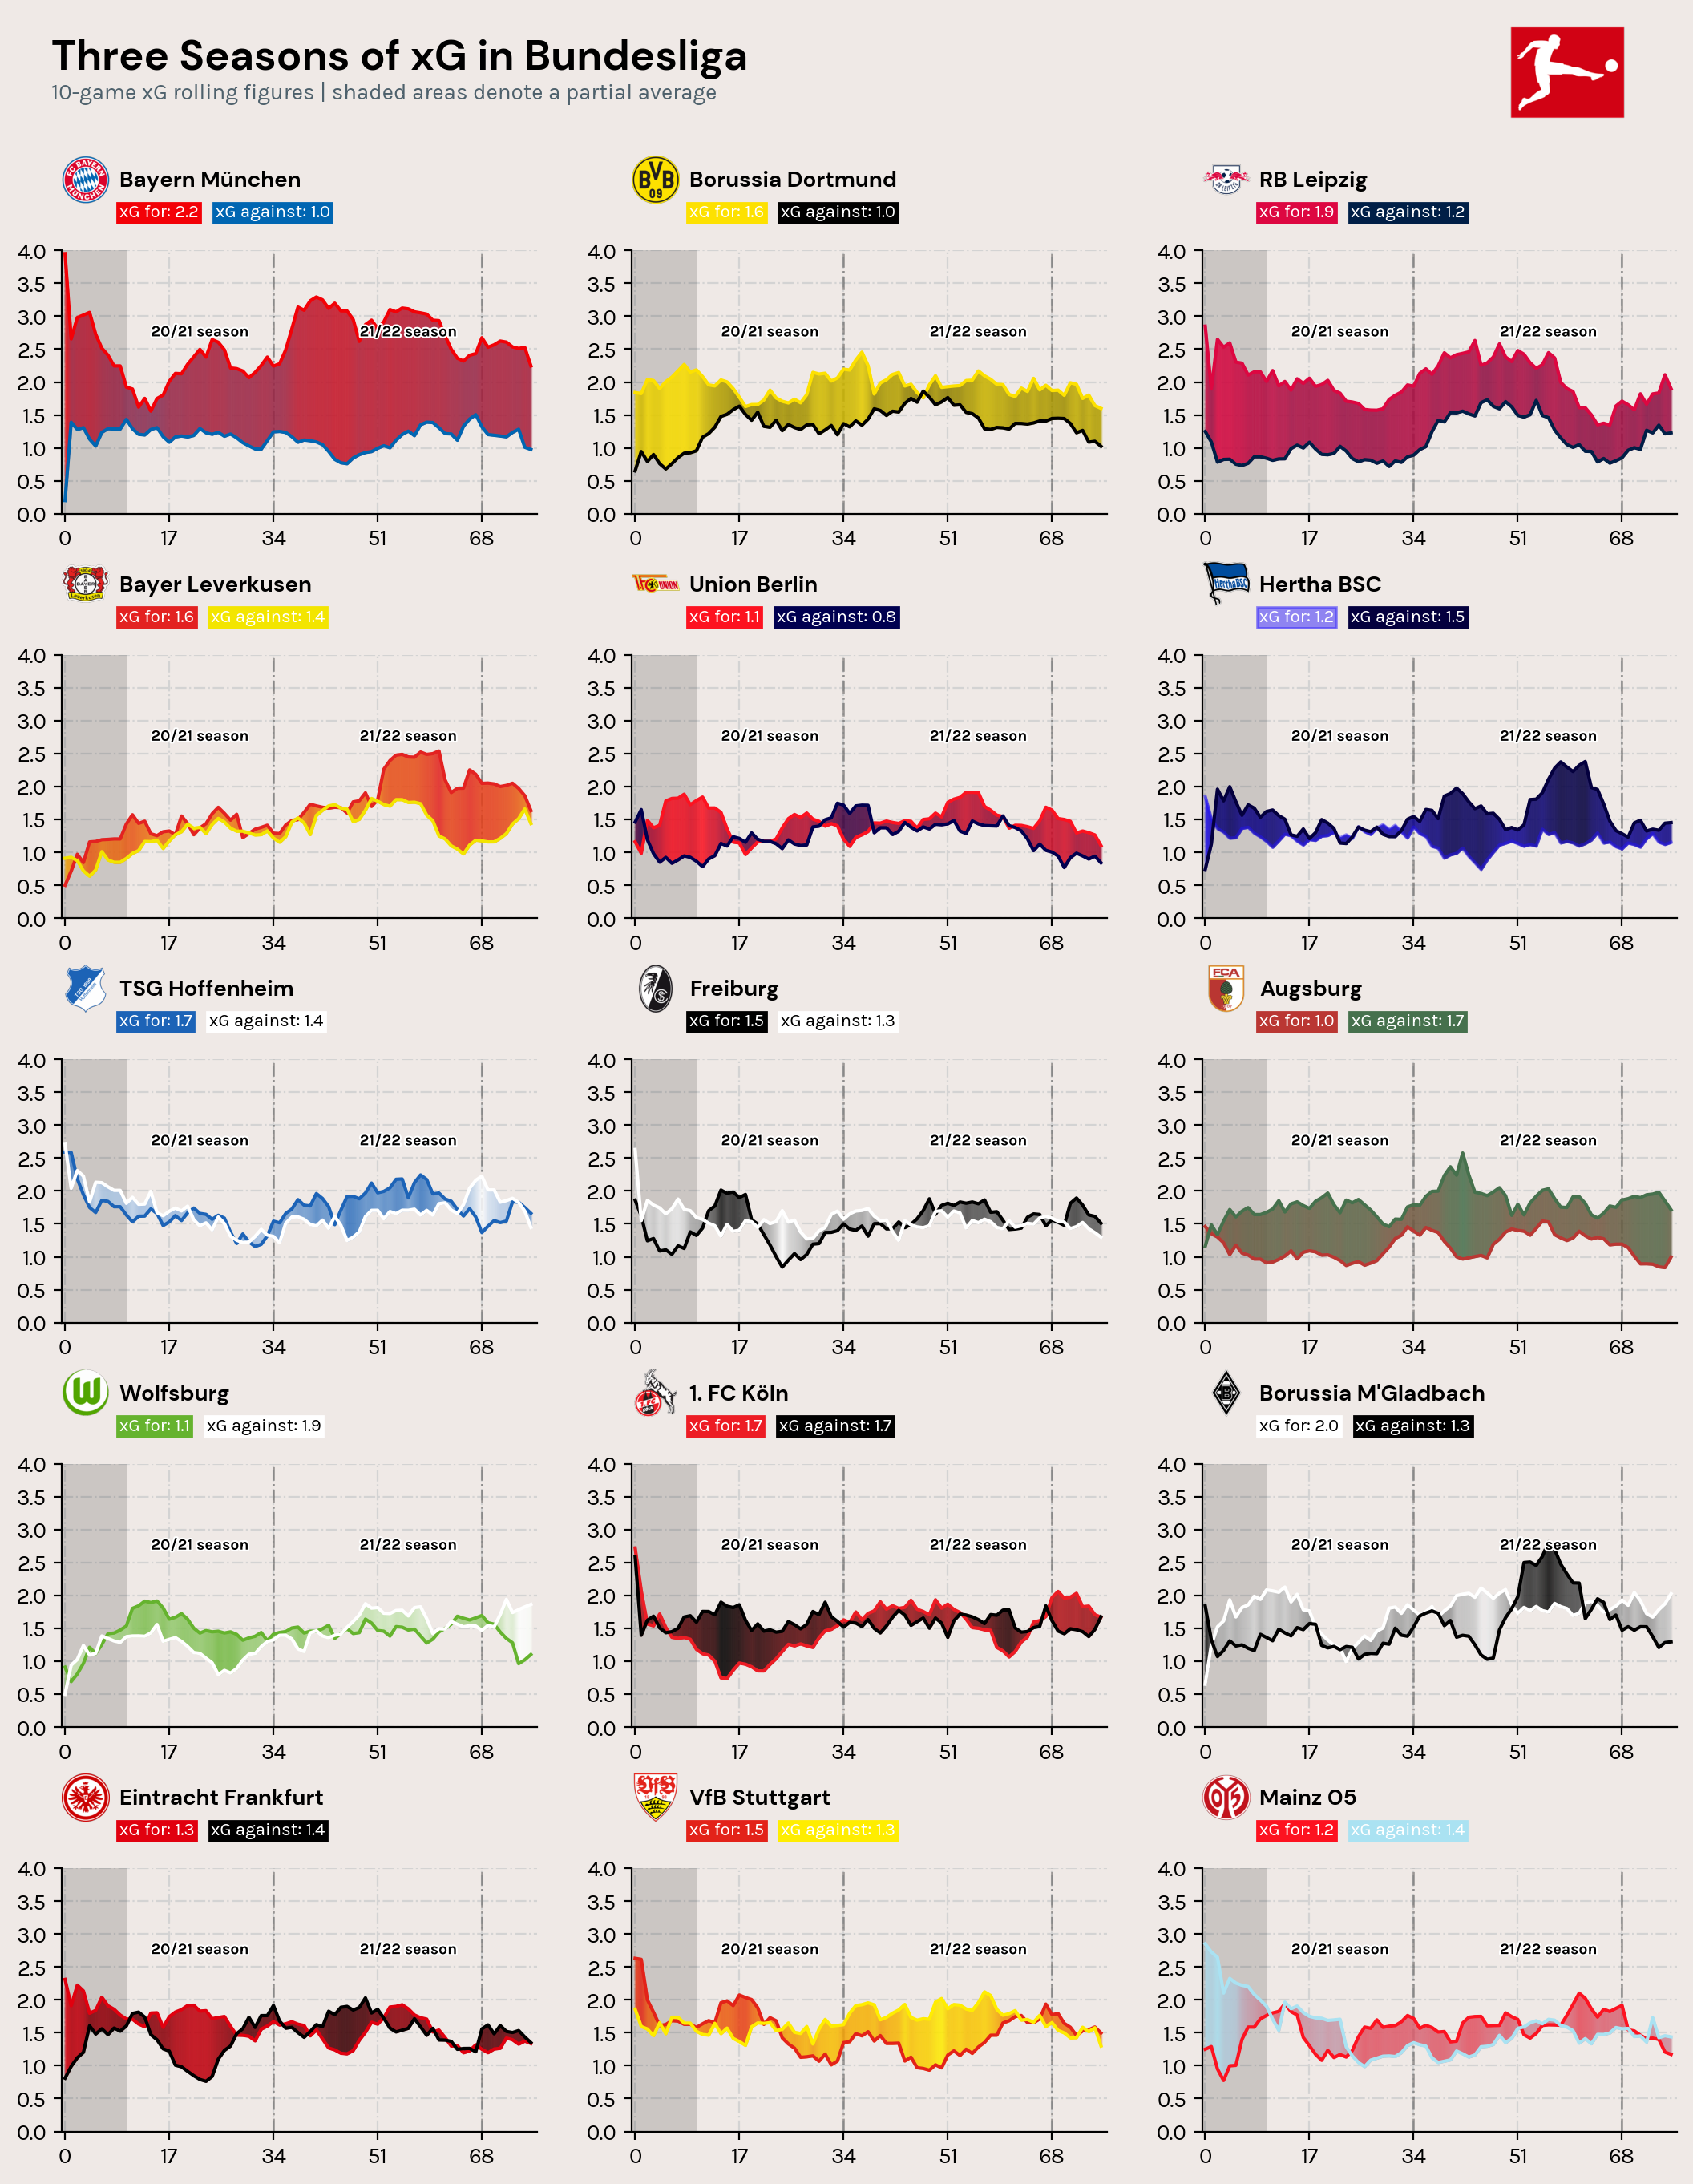

In [117]:
fig = plt.figure(figsize=(13, 16), dpi=200)
nrows = 10
ncols = 3
gspec = gridspec.GridSpec(
    ncols=ncols, nrows=nrows, figure=fig,
    height_ratios=[(1/nrows)*2.35 if x % 2 != 0 else (1/nrows)/2.35 for x in range(nrows)], hspace=.3
)

plot_counter = 0
logo_counter = 0

for row in range(nrows):
    for col in range(ncols):
        if row % 2 != 0:
            ax = plt.subplot(
                gspec[row, col],
                facecolor="#EFE9E6"
            )
            # teamId = list(big_six_cm.keys())[plot_counter]
            teamId = teams_color['team_id'].iloc[plot_counter]
            teamId = int(teamId)
            plot_xG_gradient(ax, teamId, 10)
            plot_counter += 1
        else:
            # teamId = list(big_six_cm.keys())[logo_counter]
            # color_2 = big_six_cm[str(teamId)]['high']
            # color_1 = big_six_cm[str(teamId)]['low']

            teamId = teams_color['team_id'].iloc[logo_counter]
            color_1 = teams_color[teams_color['team_id']
                                  == teamId].iloc[0]['color1']
            color_2 = teams_color[teams_color['team_id']
                                  == teamId].iloc[0]['color2']

            if color_1 in light_color:
                color_1_t = 'black'
            else:
                color_1_t = 'white'
            if color_2 in light_color:
                color_2_t = 'black'
            else:
                color_2_t = 'white'

            teamId = int(teamId)
            df_for_text = get_xG_rolling_data(teamId, 10)
            teamName = df_for_text['team_name'].iloc[0]
            xG_for = df_for_text['rolling_xG_for'].iloc[-1]
            xG_ag = df_for_text['rolling_xG_ag'].iloc[-1]
            fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
            logo_ax = plt.subplot(
                gspec[row, col],
                anchor='NW', facecolor='#EFE9E6'
            )
            club_icon = Image.open(urllib.request.urlopen(
                f'{fotmob_url}{teamId:.0f}.png'))
            logo_ax.imshow(club_icon)
            logo_ax.axis('off')

            print(f'({logo_counter+1}/15) drawing {teamName}...')

            ax_text(
                x=1.2,
                y=.7,
                s=f'<{teamName}>\n<xG for: {xG_for:.1f}> <|> <xG against: {xG_ag:.1f}>',
                ax=logo_ax,
                highlight_textprops=[
                    {'weight': 'bold', 'font': 'DM Sans'},
                    {'size': '8', 'bbox': {'edgecolor': color_2,
                                           'facecolor': color_2, 'pad': 1}, 'color': color_2_t},
                    {'color': '#EFE9E6'},
                    {'size': '8', 'bbox': {'edgecolor': color_1,
                                           'facecolor': color_1, 'pad': 1}, 'color': color_1_t},
                ],
                font='Karla',
                ha='left',
                size=10,
                annotationbbox_kw={'xycoords': 'axes fraction'}
            )
            logo_counter += 1

fig_text(
    x=.12, y=.91,
    s=f'Three Seasons of xG in {league_name}',
    va='bottom',
    ha='left',
    fontsize=19,
    color='black',
    font='DM Sans',
    weight='bold'
)
fig_text(
    x=.12, y=.9,
    s='10-game xG rolling figures | shaded areas denote a partial average',
    va='bottom',
    ha='left',
    fontsize=10,
    color='#4E616C',
    font='Karla'
)
fotmob_url = 'https://images.fotmob.com/image_resources/logo/leaguelogo/'
logo_ax = fig.add_axes([.82, .885, .055, .055])
club_icon = Image.open(urllib.request.urlopen(
    f'{fotmob_url}{league_id:.0f}.png'))
logo_ax.imshow(club_icon)
logo_ax.axis('off')

plt.savefig(
    f"figures/{filename}.png",
    dpi=600,
    facecolor='#EFE9E6',
    bbox_inches="tight",
    edgecolor="none",
    transparent=False
)
